# Time / precision

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import time
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.despine(left=True)
import dataframe_image as dfi

# from scimba.equations.domain import SpaceTensor
# from scimba.equations import domain
from modules.solver_fem_3D import FEMSolver
from modules.utils import create_tree

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<Figure size 640x480 with 0 Axes>

In [4]:
if testcase == 1:
    # if version == 1:
    #     from modules.testcases.test_1 import Run_laplacian2D,Poisson_2D
    # elif version == 2:
    #     from modules.testcases.test_1_v2 import Run_laplacian2D,Poisson_2D
    # else:
    #     raise ValueError("Version not found")
    from modules.problem_3D import TestCase1_3D
    problem = TestCase1_3D()
# elif testcase == 2:
#     from modules.testcases.test_2 import Run_laplacian2D,Poisson_2D
#     from modules.problem import TestCase2
#     problem = TestCase2()
else:
    raise ValueError("Testcase not found")

result_dir = "../results/testcase"+str(testcase)+"_3D"
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/time_precision/"
create_tree(result_dir)

In [5]:
# pde = Poisson_2D()
# trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    params = problem.parameter_domain
    # params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1]), np.random.uniform(params[2][0], params[2][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22 0.1 ]


## Convergence FEM

In [7]:
# import vedo
# vedo.settings.default_backend= 'vtk'
# vedo.Cone().show(axes=1).close()

In [9]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    tab_times_FEM = list(df_FEM['times'].values)
    tab_subtimes_FEM = {}
    for key in df_FEM.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_FEM[key] = list(df_FEM[key].values)
    
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [20,40,80]
        tab_h_FEM = []
        tab_err_FEM = []
        tab_times_FEM = []
        tab_subtimes_FEM = {}

        iter_solver = False
        for nb_vert in tab_nb_vert_FEM:
            if nb_vert>=50:
                iter_solver=True
                
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=3)
            
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0,iter_solver=iter_solver)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            
            # from vedo.dolfin import plot as vplot
            # vplot(sol, cmap='viridis', add=True, wireframe=True)
            
            tab_err_FEM.append(norme_L2)
            times_FEM = solver.times_fem
            for key in times_FEM:
                if key in tab_subtimes_FEM:
                    tab_subtimes_FEM[key].append(times_FEM[key])
                else:
                    tab_subtimes_FEM[key] = [times_FEM[key]]
            total = sum(times_FEM.values())
            print(f"total time: {total}")
            tab_times_FEM.append(total)
        
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM, 'times': tab_times_FEM, **tab_subtimes_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

In [10]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = run_FEM(degree)

Read csv file ../results/testcase1_3D/time_precision/FEM_case1_param1_degree1.csv


## Convergence PINNs+Corr

In [14]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [15]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    tab_times_Corr = list(df_Corr['times'].values)
    tab_subtimes_Corr = {}
    for key in df_Corr.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_Corr[key] = list(df_Corr[key].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []
        tab_times_Corr = []
        tab_subtimes_Corr = {}

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            start = time.time()
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            end = time.time()
            
            time_get_u_PINNs = end - start
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            times_Corr = solver.times_corr_add
            times_Corr["get_u_PINNs"] = time_get_u_PINNs
            for key in times_Corr:
                if key in tab_subtimes_Corr:
                    tab_subtimes_Corr[key].append(times_Corr[key])
                else:
                    tab_subtimes_Corr[key] = [times_Corr[key]]
            tab_times_Corr.append(sum(times_Corr.values()))
            
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr, 'times': tab_times_Corr, **tab_subtimes_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

In [16]:
# degree = 1
# df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = run_Corr(degree)

In [17]:
df_Corr

NameError: name 'df_Corr' is not defined

## Plots

In [18]:
print("subtimes FEM : ", tab_subtimes_FEM)
print("times FEM : ", tab_times_FEM)
# print("subtimes Corr : ", tab_subtimes_Corr)

subtimes FEM :  {'mesh': [0.0042357444763183, 0.0142135620117187, 0.1246802806854248], 'assemble': [50.284212827682495, 442.29187631607056, 3673.089465141296], 'solve': [0.2849161624908447, 4.993787050247192, 4.735661506652832]}
times FEM :  [50.57336473464966, 447.2998769283295, 3677.949806928634]


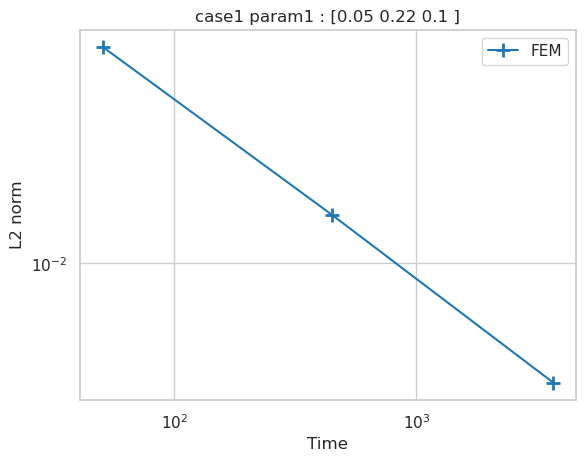

In [19]:
colors = ["tab:blue","tab:red","tab:cyan","tab:orange"]

plt.figure()

def plot_values(times,norms,color,label):
    plt.loglog(times,norms,"+-",color=color,label=label,markersize=10,markeredgewidth=2)

plot_values(tab_times_FEM,tab_err_FEM,colors[0],"FEM")
# plot_values(times_phifem,norms_phifem,colors[1],"PHIFEM")

# plot_values(tab_times_Corr,tab_err_Corr,colors[2],"Additive")
# plot_values(times_corr_add_phifem,norms_corr_add_phifem,colors[3],"Corr_add_PHIFEM")

plt.xlabel("Time")
plt.ylabel("L2 norm")

plt.legend()
plt.title(f'case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f"time_precision_param{param_num}_degree{degree}.png")

In [20]:
tab_times_FEM_ = np.round(tab_times_FEM, 0)
tab_times_FEM_ = tab_times_FEM_.astype(int)

# create string with ..h..min..s (if needed)

tab_times_FEM_str = []
for time in tab_times_FEM_:
    time_str = ""
    if time >= 3600:
        time_str += str(time//3600) + "h"
        time = time % 3600
    if time >= 60:
        time_str += str(time//60) + "min"
        time = time % 60
    if time > 0:
        time_str += str(time) + "s"
    tab_times_FEM_str.append(time_str)

In [21]:
df_time_pres = pd.DataFrame(np.array([tab_err_FEM,tab_times_FEM_str]).T,columns=["err","CPU times"],index=tab_nb_vert_FEM)
df_time_pres

,err,CPU times
20,0.0610268155205595,51s
40,0.0150110961335434,7min27s
80,0.0036898010457549,1h1min18s


## Tableau

In [23]:
# tab_subtimes_FEM["get_u_PINNs"] = None
# methods = ["FEM","Corr_FEM"]
# steps = ["mesh","get_u_PINNs","assemble","solve","TOTAL"]

# norms = {"FEM":tab_err_FEM,"Corr_FEM":tab_err_Corr}
# subtimes = {"FEM":tab_subtimes_FEM,"Corr_FEM":tab_subtimes_Corr}
# times = {"FEM":tab_times_FEM,"Corr_FEM":tab_times_Corr}

# for method in methods:
#     subtimes[method]["TOTAL"] = times[method]

# ###
# # Interpolation
# ###

# def get_index(norms,given_precision):
#     norms = np.array(norms)
#     if given_precision < norms[-1]:
#         index = len(norms)-1
#     elif given_precision > norms[0]:
#         index = 0
#     else:           
#         index = np.where(norms < given_precision)[0][0]
    
#     return index

# def linear_interpolation(norms,times,index,given_precision):
#     norms = np.array(norms)
#     times = np.array(times)
    
#     norm = norms[index-1:index+1]
#     time = times[index-1:index+1]

#     t_inter = time[0]+(time[1]-time[0])/(norm[1]-norm[0])*(given_precision-norm[0])
    
#     return t_inter

# def get_time(given_precision):
#     times_inter = {}
#     for method in methods:
#         times_inter[method] = {}
#         for key in steps:
#             if not subtimes[method][key] is None:
#                 index = get_index(norms[method],given_precision)
#                 t_inter = linear_interpolation(norms[method],subtimes[method][key],index,given_precision)
#                 times_inter[method][key] = t_inter
#             else:
#                 times_inter[method][key] = None
#     return times_inter

In [24]:
# given_precision = 1e-3
# times_inter = get_time(given_precision)
# # Create a dataframe with the times interpolated
# df_given_precision = pd.DataFrame.from_dict(times_inter).T
# # réorganiser lignes et colonnes par clés
# df_given_precision = df_given_precision.reindex(methods)
# df_given_precision = df_given_precision[steps]
# # Create an excel file with the times

# df_given_precision

In [26]:
# pre = int(np.log10(given_precision))
# result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

# df_given_precision.to_excel(result_file+'.xlsx')

# df_styled = df_given_precision.style.format("{:.2e}")
# dfi.export(df_styled,result_file+".png",dpi=1000)

In [27]:
# given_precision = 1e-4
# times_inter = get_time(given_precision)
# # Create a dataframe with the times interpolated
# df_given_precision = pd.DataFrame.from_dict(times_inter).T
# # réorganiser lignes et colonnes par clés
# df_given_precision = df_given_precision.reindex(methods)
# df_given_precision = df_given_precision[steps]
# # Create an excel file with the times

# df_given_precision

In [28]:
# pre = int(np.log10(given_precision))
# result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

# df_given_precision.to_excel(result_file+'.xlsx')

# df_styled = df_given_precision.style.format("{:.2e}")
# dfi.export(df_styled,result_file+".png",dpi=1000)

In [29]:
# df_time_pres